In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In pip, the `-q` or `--quiet` option means to run the installation command without any output, except for error messages. This is useful when you want to suppress the installation details and only view the final output.

In [ ]:
!conda --version
!which conda

conda 23.1.0
/usr/local/bin/conda


In [ ]:
!conda install -c conda-forge nest-simulator >/dev/null

In the above chunk, `>/dev/null` redirects the standard output of a command to `/dev/null`, which is a special file in Unix-like systems that discards all the data written to it. Then, there is no output, like using `-q` in "pip install" (but using `-q` or `--quiet` in "conda install" still leads to (part of) output -- a little confusing). 

If we also use `2>&1`, which redirects the standard error of the command to the same location as the standard output, then together, `>/dev/null 2>&1` redirects both standard output and standard error to `/dev/null`, which effectively suppresses all output from the command. 

So, `>/dev/null` only redirects the standard output of the command to `/dev/null`, leaving the standard error untouched. Any error messages generated by the command will still be displayed on the screen. We use `>/dev/null` here.

There is another flag `-y`, which is a common command-line option used in package managers like apt-get and yum. It is used to automatically answer "yes" to any prompts that may come up during installation or upgrading of packages, avoiding the need for user input. But it is not needed here, becuase no questions in the installation.

In [ ]:
# Loading the necessary modules:
import numpy as np
import matplotlib.pyplot as plt
import nest
import time

## Mesoscopic model function

Adpat is True.
20000
30.073757648468018


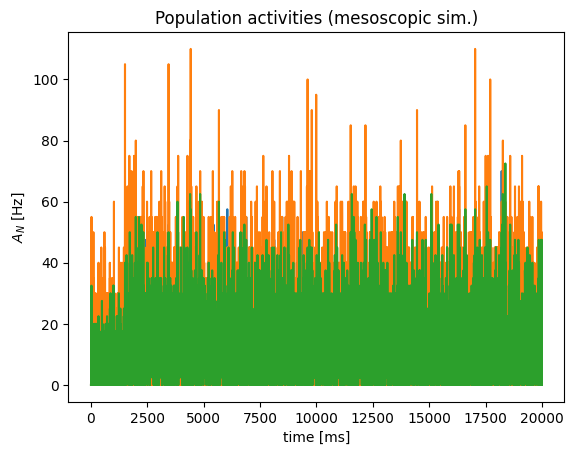

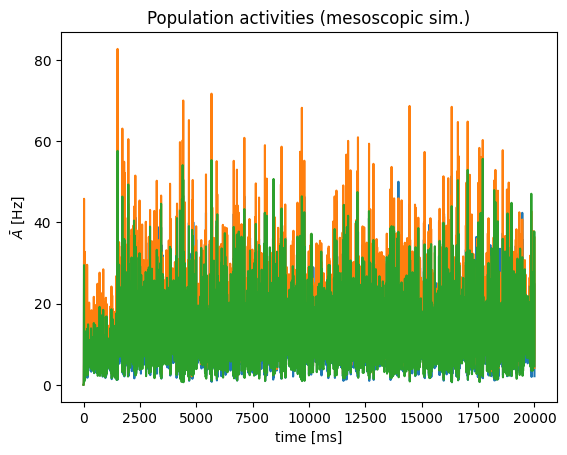

In [ ]:
def mesoscopic(pops, pops_prop, connect_mat, mu, tau_m, V_th, 
               J_theta, tau_theta, pconn, adapt=True, seed=1):
    # simulation time interval and record time interval
    dt = 0.5
    dt_rec = 1.

    # simulation time
    t_end = 20000.

    # populations and their neuron numbers
    N = pops
    M = len(N) # numbers of populations

    # neuronal parameters
    t_ref = 4. * np.ones(M)  # absolute refractory period
    V_reset = 0. * np.ones(M)    # Reset potential

    # exponential link function for the conditional intensity (also called hazard rate, escape rate or conditional rate)
    c = 10. * np.ones(M)     # base rate of exponential link function
    Delta_u = 2.5 * np.ones(M)   # softness of exponential link function

    # connectivity
    # pconn = pconn_coeff * np.ones((M, M)) # probability of connections
    delay = 1. * np.ones((M, M)) # every two populations have a delay constant
    J_syn = connect_mat # synaptic weights

    # step current input
    step = [[20.] for i in range(M)]  # jump size of mu in mV
    tstep = np.array([[1500.] for i in range(M)])  # times of jumps

    # synaptic time constants of excitatory and inhibitory connections
    # for calculating post-synaptic currents caused by each spike of presynaptic neurons
    tau_ex = 3.  # in ms,
    tau_in = 6.  # in ms

    start_time = time.time()

    nest.set_verbosity("M_WARNING")
    nest.ResetKernel()
    nest.resolution = dt
    nest.print_time = True
    nest.local_num_threads = 1

    t0 = nest.biological_time

    nest_pops = nest.Create('gif_pop_psc_exp', M)

    C_m = 250.  # irrelevant value for membrane capacity, cancels out in simulation
    g_L = C_m / tau_m

    if adapt:
        q_sfa_array = J_theta / tau_theta # [J_theta]= mV*ms -> [q_sfa]=mV
        print("Adpat is True.")
    else:
        q_sfa_array = np.zeros_like(J_theta / tau_theta)
        print("Adpat is False.")

    params = [{
        'C_m': C_m,
        'I_e': mu[i] * g_L[i],
        'lambda_0': c[i],  # in Hz!
        'Delta_V': Delta_u[i],
        'tau_m': tau_m[i],
        'tau_sfa': tau_theta[i],
        'q_sfa': q_sfa_array[i],  
        'V_T_star': V_th[i],
        'V_reset': V_reset[i],
        'len_kernel': -1,  # -1 triggers automatic history size
        'N': N[i],
        't_ref': t_ref[i],
        'tau_syn_ex': max([tau_ex, dt]),
        'tau_syn_in': max([tau_in, dt]),
        'E_L': 0.
    } for i in range(M)]
    nest_pops.set(params)

    # connect the populations
    g_syn = np.ones_like(J_syn)  # synaptic conductance
    for i, prop in enumerate(pops_prop):
        if prop == 1:
            g_syn[:, i] = C_m / tau_ex
        else:
            g_syn[:, i] = C_m / tau_in
    for i in range(M):
        for j in range(M):
            nest.Connect(nest_pops[j], nest_pops[i],
                        syn_spec={'weight': J_syn[i, j] * g_syn[i, j] * pconn[i, j],
                                  'delay': delay[i, j]})

    # monitor the output using a multimeter, this only records with dt_rec!
    nest_mm = nest.Create('multimeter')
    nest_mm.set(record_from=['n_events', 'mean'], interval=dt_rec)
    nest.Connect(nest_mm, nest_pops)

    # monitor the output using a spike recorder
    nest_sr = []
    for i in range(M):
        nest_sr.append(nest.Create('spike_recorder'))
        nest_sr[i].time_in_steps = True
        nest.Connect(nest_pops[i], nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

    # set initial value (at t0+dt) of step current generator to zero
    tstep = np.hstack((dt * np.ones((M, 1)), tstep))
    step = np.hstack((np.zeros((M, 1)), step))

    # create the step current devices
    nest_stepcurrent = nest.Create('step_current_generator', M)
    # set the parameters for the step currents
    for i in range(M):
        nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                                amplitude_values=step[i] * g_L[i],
                                origin=t0,
                                stop=t_end)
        pop_ = nest_pops[i]
        nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

    # begin simulation for output
    nest.rng_seed = seed

    t = np.arange(0., t_end, dt_rec)
    A_N = np.ones((t.size, M)) * np.nan
    Abar = np.ones_like(A_N) * np.nan

    # simulate 1 step longer to make sure all t are simulated
    nest.Simulate(t_end + dt)
    data_mm = nest_mm.events
    for i, nest_i in enumerate(nest_pops):
        a_i = data_mm['mean'][data_mm['senders'] == nest_i.global_id]
        a = a_i / N[i] / dt
        min_len = np.min([len(a), len(Abar)])
        Abar[:min_len, i] = a[:min_len]

        data_sr = nest_sr[i].get('events', 'times')
        data_sr = data_sr * dt - t0
        bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
        A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
        A_N[:, i] = A

    end_time = time.time()
    elapsed_time = end_time - start_time

    return A_N, Abar, elapsed_time, t


# pops = np.array([800, 200, 100, 200, 200, 200, 200, 300])
# pops_prop = np.array([1, -1, 1, -1, 1, -1, 1, 1]) # 1: excitatory, -1: inhibitory
pops = np.array([400, 200, 400])
pops_prop = np.array([1, -1, 1]) # 1: excitatory, -1: inhibitory

pconn = np.array([[1, 1, 0],
          [1, 1, 1],
          [0, 1, 1]])
J = 0.0624  # excitatory synaptic weight in mV 
g = 0.496/0.0624   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
J_syn = np.outer(np.ones_like(pops_prop), np.where(pops_prop == -1, -g*J, J))
J_syn = J_syn * pconn

pconn_coeff = 1
pconn = pconn * pconn_coeff

mu = 36. * np.ones(len(pops)) # V_rest + I_external * R
tau_m = 20 * np.ones(len(pops))  # membrane time constant
V_th = 15. * np.ones(len(pops))  # baseline threshold (non-accumulating part)

tau_sfa_exc = [1000., 1000.]  # threshold adaptation time constants of excitatory neurons
tau_sfa_inh = [1000., 1000.]  # threshold adaptation time constants of inhibitory neurons
J_sfa_exc = [100., 1000.]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
J_sfa_inh = [100., 1000.]   # in mV*ms
tau_theta = np.array([tau_sfa_exc if prop == 1 else tau_sfa_inh for prop in pops_prop])
J_theta = np.array([J_sfa_exc if prop == 1 else J_sfa_inh for prop in pops_prop])

A_N, Abar, elapsed_time, t = mesoscopic(pops=pops, 
                      pops_prop=pops_prop, 
                      connect_mat=J_syn, 
                      mu=mu, 
                      tau_m=tau_m, 
                      V_th=V_th, 
                      J_theta=J_theta, 
                      tau_theta=tau_theta,
                      pconn=pconn,
                      adapt=True,
                      seed=1)

plt.figure()
plt.plot(t, A_N * 1000)  # plot population activities (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
plt.figure()
plt.plot(t, Abar * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
print(len(A_N))
print(elapsed_time)

# A_N_total = 0
# seed_num = 1000
# for seed_i in range(seed_num):
#     A_N, Abar, elapsed_time, t = mesoscopic(pops=pops, 
#                           pops_prop=pops_prop, 
#                           connect_mat=J_syn, 
#                           mu=mu, 
#                           tau_m=tau_m, 
#                           V_th=V_th, 
#                           J_theta=J_theta, 
#                           tau_theta=tau_theta,
#                           pconn=pconn,
#                           adapt=True,
#                           seed=seed_i+1)
#     A_N_total = A_N_total + A_N
# A_N_avg = A_N_total / seed_num

# plt.figure()
# plt.plot(t, A_N_avg * 1000)  # plot population activities (in Hz)
# plt.ylabel(r'$A_N_avg$ [Hz]')
# plt.xlabel('time [ms]')
# plt.title('Population activities (mesoscopic sim.)')

20000
28.8308846950531


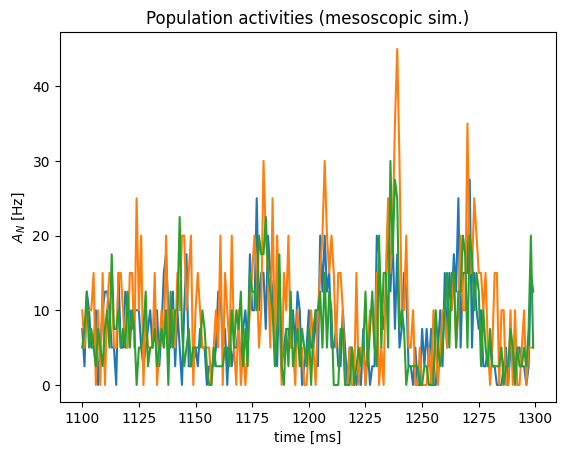

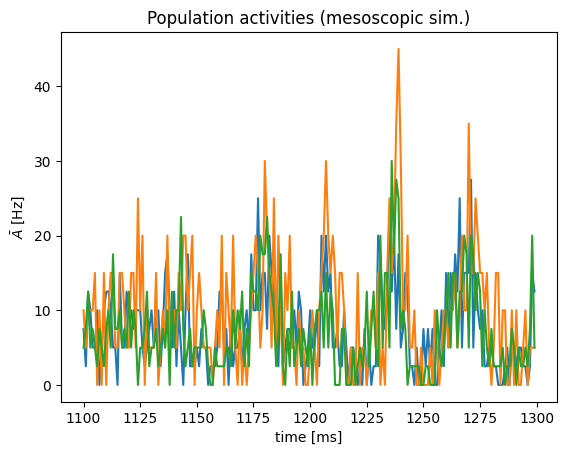

In [ ]:
plt.figure()
plt.plot(t[1100:1300], A_N[1100:1300] * 1000)  # plot population activities (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
plt.figure()
plt.plot(t[1100:1300], A_N[1100:1300] * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
print(len(A_N))
print(elapsed_time)

### Shuqi's parameters

Adpat is True.
100000
11.2387056350708


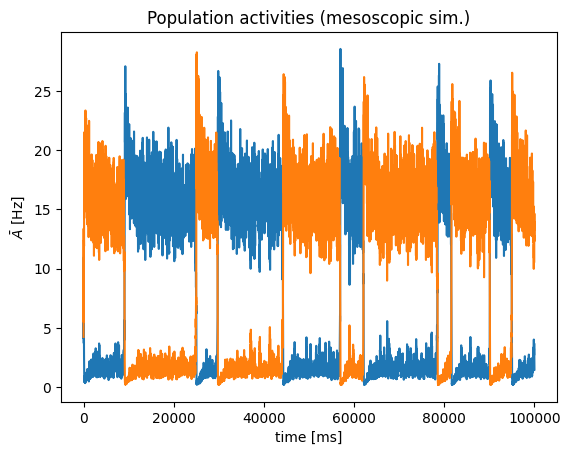

In [ ]:
def mesoscopic(pops, pops_prop, connect_mat, mu, tau_m, V_th,
               J_theta, tau_theta, pconn, adapt=True, seed=1):
    # simulation time interval and record time interval
    dt = 0.5
    dt_rec = 1.

    # simulation time
    t_end = 100000.

    # populations and their neuron numbers
    N = pops
    M = len(N) # numbers of populations

    # neuronal parameters
    t_ref = 4. * np.ones(M)  # absolute refractory period
    V_reset = 0. * np.ones(M)    # Reset potential

    # exponential link function for the conditional intensity (also called hazard rate, escape rate or conditional rate)
    c = 10. * np.ones(M)     # base rate of exponential link function
    Delta_u = 2.5 * np.ones(M)   # softness of exponential link function

    # connectivity
    # pconn = pconn_coeff * np.ones((M, M)) # probability of connections
    delay = 1. * np.ones((M, M)) # every two populations have a delay constant
    J_syn = connect_mat # synaptic weights

    # step current input
    step = [[0.] for i in range(M)]  # jump size of mu in mV
    tstep = np.array([[1500.] for i in range(M)])  # times of jumps

    # synaptic time constants of excitatory and inhibitory connections
    # for calculating post-synaptic currents caused by each spike of presynaptic neurons
    tau_ex = 3.  # in ms,
    tau_in = 6.  # in ms

    start_time = time.time()

    nest.set_verbosity("M_WARNING")
    nest.ResetKernel()
    nest.resolution = dt
    nest.print_time = True
    nest.local_num_threads = 1

    t0 = nest.biological_time

    nest_pops = nest.Create('gif_pop_psc_exp', M)

    C_m = 250.  # irrelevant value for membrane capacity, cancels out in simulation
    g_L = C_m / tau_m

    if adapt:
        q_sfa_array = J_theta / tau_theta # [J_theta]= mV*ms -> [q_sfa]=mV
        print("Adpat is True.")
    else:
        q_sfa_array = np.zeros_like(J_theta / tau_theta)
        print("Adpat is False.")

    params = [{
        'C_m': C_m,
        'I_e': mu[i] * g_L[i],
        'lambda_0': c[i],  # in Hz!
        'Delta_V': Delta_u[i],
        'tau_m': tau_m[i],
        'tau_sfa': tau_theta[i],
        'q_sfa': q_sfa_array[i], 
        'V_T_star': V_th[i],
        'V_reset': V_reset[i],
        'len_kernel': -1,  # -1 triggers automatic history size
        'N': N[i],
        't_ref': t_ref[i],
        'tau_syn_ex': max([tau_ex, dt]),
        'tau_syn_in': max([tau_in, dt]),
        'E_L': 0.
    } for i in range(M)]
    nest_pops.set(params)

    # connect the populations
    g_syn = np.ones_like(J_syn)  # synaptic conductance
    for i, prop in enumerate(pops_prop):
        if prop == 1:
            g_syn[:, i] = C_m / tau_ex
        else:
            g_syn[:, i] = C_m / tau_in
    for i in range(M):
        for j in range(M):
            nest.Connect(nest_pops[j], nest_pops[i],
                        syn_spec={'weight': J_syn[i, j] * g_syn[i, j] * pconn[i, j],
                                  'delay': delay[i, j]})

    # monitor the output using a multimeter, this only records with dt_rec!
    nest_mm = nest.Create('multimeter')
    nest_mm.set(record_from=['n_events', 'mean'], interval=dt_rec)
    nest.Connect(nest_mm, nest_pops)

    # monitor the output using a spike recorder
    nest_sr = []
    for i in range(M):
        nest_sr.append(nest.Create('spike_recorder'))
        nest_sr[i].time_in_steps = True
        nest.Connect(nest_pops[i], nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

    # set initial value (at t0+dt) of step current generator to zero
    tstep = np.hstack((dt * np.ones((M, 1)), tstep))
    step = np.hstack((np.zeros((M, 1)), step))

    # create the step current devices
    nest_stepcurrent = nest.Create('step_current_generator', M)
    # set the parameters for the step currents
    for i in range(M):
        nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                                amplitude_values=step[i] * g_L[i],
                                origin=t0,
                                stop=t_end)
        pop_ = nest_pops[i]
        nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

    # begin simulation for output
    nest.rng_seed = seed

    t = np.arange(0., t_end, dt_rec)
    A_N = np.ones((t.size, M)) * np.nan
    Abar = np.ones_like(A_N) * np.nan

    # simulate 1 step longer to make sure all t are simulated
    nest.Simulate(t_end + dt)
    data_mm = nest_mm.events
    for i, nest_i in enumerate(nest_pops):
        a_i = data_mm['mean'][data_mm['senders'] == nest_i.global_id]
        a = a_i / N[i] / dt
        min_len = np.min([len(a), len(Abar)])
        Abar[:min_len, i] = a[:min_len]

        data_sr = nest_sr[i].get('events', 'times')
        data_sr = data_sr * dt - t0
        bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
        A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
        A_N[:, i] = A

    end_time = time.time()
    elapsed_time = end_time - start_time

    return A_N, Abar, elapsed_time, t


# pops = np.array([800, 200, 100, 200, 200, 200, 200, 300])
# pops_prop = np.array([1, -1, 1, -1, 1, -1, 1, 1]) # 1: excitatory, -1: inhibitory
pops = np.array([400, 200, 400])
pops_prop = np.array([1, -1, 1]) # 1: excitatory, -1: inhibitory

pconn = np.array([[1, 1, 0],
          [1, 1, 1],
          [0, 1, 1]])
J = 0.096  # excitatory synaptic weight in mV
g = 0.384/0.096   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
J_syn = np.outer(np.ones_like(pops_prop), np.where(pops_prop == -1, -g*J, J))
J_syn = J_syn * pconn

pconn_coeff = 1
pconn = pconn * pconn_coeff

mu = 36. * np.ones(len(pops)) # V_rest + I_external * R
tau_m = 20 * np.ones(len(pops))  # membrane time constant
V_th = 15. * np.ones(len(pops))  # baseline threshold (non-accumulating part)

tau_sfa_exc = [1000.]  # threshold adaptation time constants of excitatory neurons
tau_sfa_inh = [1000.]  # threshold adaptation time constants of inhibitory neurons
J_sfa_exc = [100.]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
J_sfa_inh = [100.]   # in mV*ms
tau_theta = np.array([tau_sfa_exc if prop == 1 else tau_sfa_inh for prop in pops_prop])
J_theta = np.array([J_sfa_exc if prop == 1 else J_sfa_inh for prop in pops_prop])

A_N, Abar, elapsed_time, t = mesoscopic(pops=pops,
                      pops_prop=pops_prop,
                      connect_mat=J_syn,
                      mu=mu,
                      tau_m=tau_m,
                      V_th=V_th,
                      J_theta=J_theta,
                      tau_theta=tau_theta,
                      pconn=pconn,
                      adapt=True,
                      seed=1)


from scipy.ndimage import gaussian_filter1d
plt.figure()
for popi in [0,2]:
    plt.plot(t, gaussian_filter1d(Abar[:,popi],10) * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
print(len(A_N))
print(elapsed_time)

100000
12.321024894714355


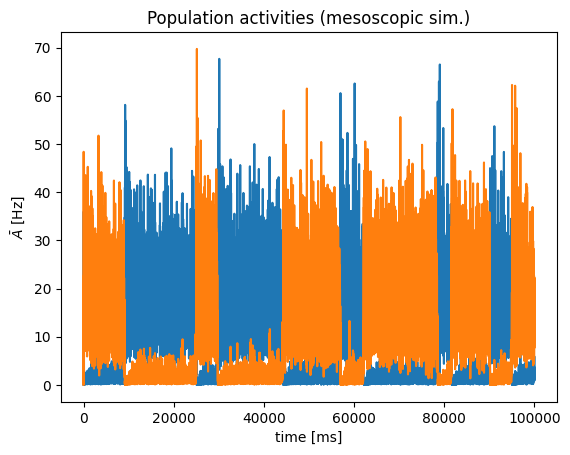

In [ ]:
from scipy.ndimage import gaussian_filter1d
plt.figure()
for popi in [0,2]:
    plt.plot(t, Abar[:,popi] * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
print(len(A_N))
print(elapsed_time)

100000
12.321024894714355


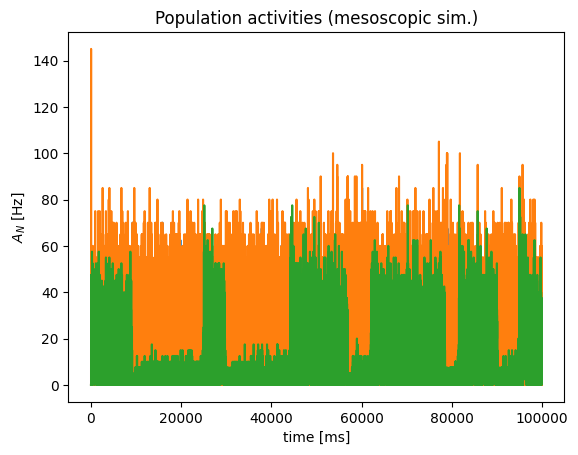

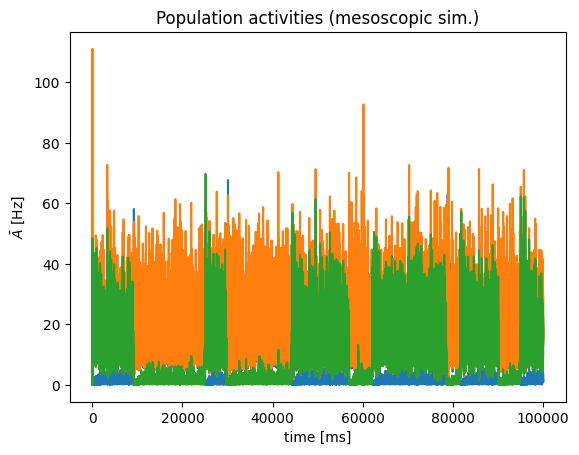

In [ ]:
plt.figure()
plt.plot(t, A_N * 1000)  # plot population activities (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
plt.figure()
plt.plot(t, Abar * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
print(len(A_N))
print(elapsed_time)

## Microscopic model function

Adpat is True.
2000
4.491290330886841


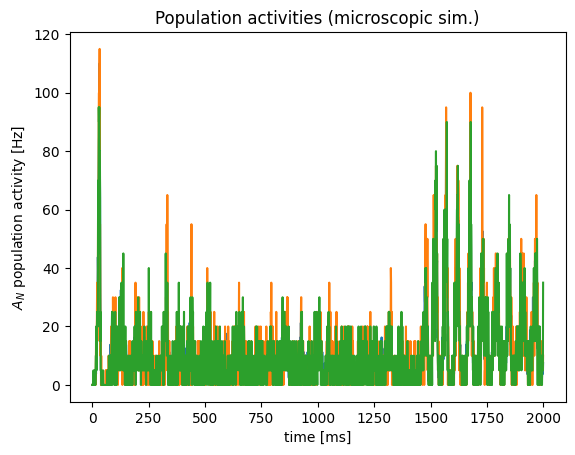

In [ ]:
def microscopic(pops, pops_prop, connect_mat, mu, tau_m, V_th, 
               J_theta, tau_theta, pconn, adapt=True, seed=1):
    # simulation time interval and record time interval
    dt = 0.5
    dt_rec = 1.

    # simulation time
    t_end = 2000.

    # populations and their neuron numbers
    N = pops
    M = len(N) # numbers of populations

    # neuronal parameters
    t_ref = 4. * np.ones(M)  # absolute refractory period
    V_reset = 0. * np.ones(M)    # Reset potential

    # exponential link function for the conditional intensity (also called hazard rate, escape rate or conditional rate)
    c = 10. * np.ones(M)     # base rate of exponential link function
    Delta_u = 2.5 * np.ones(M)   # softness of exponential link function

    # connectivity
    # pconn = pconn_coeff * np.ones((M, M)) # probability of connections
    delay = 1. * np.ones((M, M)) # every two populations have a delay constant
    J_syn = connect_mat # synaptic weights

    # step current input
    step = [[20.] for i in range(M)]  # jump size of mu in mV
    tstep = np.array([[1500.] for i in range(M)])  # times of jumps

    # synaptic time constants of excitatory and inhibitory connections
    # for calculating post-synaptic currents caused by each spike of presynaptic neurons
    tau_ex = 3.  # in ms,
    tau_in = 6.  # in ms

    start_time = time.time()

    nest.set_verbosity("M_WARNING")
    nest.ResetKernel()
    nest.resolution = dt
    nest.print_time = True
    nest.local_num_threads = 1

    t0 = nest.biological_time

    nest_pops = []
    for k in range(M):
        nest_pops.append(nest.Create('gif_psc_exp', N[k]))

    C_m = 250.  # irrelevant value for membrane capacity, cancels out in simulation
    g_L = C_m / tau_m

    if adapt:
        q_sfa_array = J_theta / tau_theta # [J_theta]= mV*ms -> [q_sfa]=mV
        print("Adpat is True.")
    else:
        q_sfa_array = np.zeros_like(J_theta / tau_theta)
        print("Adpat is False.")

    # set single neuron properties

    for i in range(M):
        nest_pops[i].set(C_m=C_m,
                I_e=mu[i] * g_L[i],
                lambda_0=c[i],
                Delta_V=Delta_u[i],
                g_L=g_L[i],
                tau_sfa=tau_theta[i],
                q_sfa=q_sfa_array[i],
                V_T_star=V_th[i],
                V_reset=V_reset[i],
                t_ref=t_ref[i],
                tau_syn_ex=max([tau_ex, dt]),
                tau_syn_in=max([tau_in, dt]),
                E_L=0.,
                V_m=0.)

    # connect the populations
    g_syn = np.ones_like(J_syn)  # synaptic conductance
    for i, prop in enumerate(pops_prop):
        if prop == 1:
            g_syn[:, i] = C_m / tau_ex
        else:
            g_syn[:, i] = C_m / tau_in
        
    # connect the populations
    for i, nest_i in enumerate(nest_pops):
        for j, nest_j in enumerate(nest_pops):
            if np.allclose(pconn[i, j], 1.):
                conn_spec = {'rule': 'all_to_all'}
            else:
                conn_spec = {
                    'rule': 'fixed_indegree', 'indegree': int(pconn[i, j] * N[j])}

            nest.Connect(nest_j, nest_i,
                        conn_spec,
                        syn_spec={'weight': J_syn[i, j] * g_syn[i, j],
                                  'delay': delay[i, j]})

    # monitor the output using a multimeter and a spike recorder
    nest_sr = []
    for i, nest_i in enumerate(nest_pops):
        nest_sr.append(nest.Create('spike_recorder'))
        nest_sr[i].time_in_steps = True

        # record all spikes from population to compute population activity
        nest.Connect(nest_i, nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

    Nrecord = [5 for i in range(M)]    # for each population "i" the first Nrecord[i] neurons are recorded
    nest_mm_Vm = []
    for i, nest_i in enumerate(nest_pops):
        nest_mm_Vm.append(nest.Create('multimeter'))
        nest_mm_Vm[i].set(record_from=['V_m'], interval=dt_rec)
        if Nrecord[i] != 0:
            nest.Connect(nest_mm_Vm[i], nest_i[:Nrecord[i]], syn_spec={'weight': 1., 'delay': dt})

    # set initial value (at t0+dt) of step current generator to zero
    tstep = np.hstack((dt * np.ones((M, 1)), tstep))
    step = np.hstack((np.zeros((M, 1)), step))

    # create the step current devices if they do not exist already
    nest_stepcurrent = nest.Create('step_current_generator', M)
    # set the parameters for the step currents
    for i in range(M):
        nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                                amplitude_values=step[i] * g_L[i],
                                origin=t0,
                                stop=t_end)
        nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                                amplitude_values=step[i] * g_L[i],
                                origin=t0,
                                stop=t_end)
        # optionally a stopping time may be added by: 'stop': sim_T + t0
        pop_ = nest_pops[i]
        nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

    # start the microscopic simulation
    nest.rng_seed = seed

    t = np.arange(0., t_end, dt_rec)
    A_N = np.ones((t.size, M)) * np.nan

    # simulate 1 step longer to make sure all t are simulated
    nest.Simulate(t_end + dt)

    for i in range(len(nest_pops)):
        data_sr = nest_sr[i].get('events', 'times') * dt - t0
        bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
        A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
        A_N[:, i] = A * 1000  # in Hz

    end_time = time.time()
    elapsed_time = end_time - start_time

    return A_N, elapsed_time, t


pops = np.array([800, 200, 200])
pops_prop = np.array([1, -1, 1]) # 1: excitatory, -1: inhibitory
# pops = np.array([800, 200])
# pops_prop = np.array([1, -1]) # 1: excitatory, -1: inhibitory

pconn = np.array([[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]])
# pconn = np.array([[1, 1],
#           [1, 1]])
J = 0.3  # excitatory synaptic weight in mV 
g = 5.   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
J_syn = np.outer(np.ones_like(pops_prop), np.where(pops_prop == -1, -g*J, J))
J_syn = J_syn * pconn

pconn_coeff = 0.2
pconn = pconn * pconn_coeff

mu = 24. * np.ones(len(pops)) # V_rest + I_external * R
tau_m = 20. * np.ones(len(pops))  # membrane time constant
V_th = 15. * np.ones(len(pops))  # baseline threshold (non-accumulating part)

tau_sfa_exc = [100., 1000.]  # threshold adaptation time constants of excitatory neurons
tau_sfa_inh = [100., 1000.]  # threshold adaptation time constants of inhibitory neurons
J_sfa_exc = [1000., 1000.]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
J_sfa_inh = [1000., 1000.]   # in mV*ms
tau_theta = np.array([tau_sfa_exc if prop == 1 else tau_sfa_inh for prop in pops_prop])
J_theta = np.array([J_sfa_exc if prop == 1 else J_sfa_inh for prop in pops_prop])

A_N, elapsed_time, t = microscopic(pops=pops, 
                    pops_prop=pops_prop, 
                    connect_mat=J_syn, 
                    mu=mu, 
                    tau_m=tau_m, 
                    V_th=V_th, 
                    J_theta=J_theta, 
                    tau_theta=tau_theta,
                    pconn=pconn,
                    adapt=True,
                    seed=1)

plt.figure()
plt.plot(t, A_N)
plt.xlabel('time [ms]')
plt.ylabel(r'$A_N$ population activity [Hz]')
plt.title('Population activities (microscopic sim.)')
print(len(A_N))
print(elapsed_time)

A_N_total = 0
seed_num = 1000
for seed_i in range(seed_num):
    A_N, elapsed_time, t = microscopic(pops=pops, 
                        pops_prop=pops_prop, 
                        connect_mat=J_syn, 
                        mu=mu, 
                        tau_m=tau_m, 
                        V_th=V_th, 
                        J_theta=J_theta, 
                        tau_theta=tau_theta,
                        pconn=pconn,
                        adapt=True,
                        seed=seed_i)
    A_N_total = A_N_total + A_N
A_N_avg = A_N_total / seed_num

plt.figure()
plt.plot(t, A_N_avg * 1000)  # plot population activities (in Hz)
plt.ylabel(r'$A_N_avg$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (microscopic sim.)')

## Mesoscopic model

In [ ]:
# simulation time interval and record time interval
dt = 0.5
dt_rec = 1.

# simulation time
t_end = 2000.

# populations and their neuron numbers
N = np.array([800, 200])
M = len(N) # numbers of populations

# neuronal parameters
t_ref = 4. * np.ones(M)  # absolute refractory period
tau_m = 20 * np.ones(M)  # membrane time constant
V_rest = 0 * np.ones(M) # resting potential
mu = 24. * np.ones(M)    # constant base current mu=R*I0
V_reset = 0. * np.ones(M)    # Reset potential
V_th = 15. * np.ones(M)  # baseline threshold (non-accumulating part)

# exponential link function for the conditional intensity (also called hazard rate, escape rate or conditional rate)
c = 10. * np.ones(M)     # base rate of exponential link function
Delta_u = 2.5 * np.ones(M)   # softness of exponential link function

# threshold adaptation
tau_sfa_exc = [100., 1000.]  # threshold adaptation time constants of excitatory neurons
tau_sfa_inh = [100., 1000.]  # threshold adaptation time constants of inhibitory neurons
J_sfa_exc = [1000., 1000.]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
J_sfa_inh = [1000., 1000.]   # in mV*ms
tau_theta = np.array([tau_sfa_exc, tau_sfa_inh])
J_theta = np.array([J_sfa_exc, J_sfa_inh])

# connectivity
J = 0.3  # excitatory synaptic weight in mV if number of input connections is C0 (see below)
g = 5.   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
pconn = 0.2 * np.ones((M, M)) # probability of connections
delay = 1. * np.ones((M, M)) # every two populations have a delay constant
C0 = np.array([[800, 200], [800, 200]]) * 0.2  # constant reference matrix for connections
C = np.vstack((N, N)) * pconn  # numbers of input connections
J_syn = np.array([[J, -g * J], [J, -g * J]]) * C0 / C # final synaptic weights scaling as 1/C

# step current input
step = [[20.], [20.]]  # jump size of mu in mV
tstep = np.array([[1500.], [1500.]])  # times of jumps

# synaptic time constants of excitatory and inhibitory connections
# for calculating post-synaptic currents caused by each spike of presynaptic neurons
tau_ex = 3.  # in ms,
tau_in = 6.  # in ms

In [ ]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()
nest.resolution = dt
nest.print_time = True
nest.local_num_threads = 1

t0 = nest.biological_time

nest_pops = nest.Create('gif_pop_psc_exp', M)

C_m = 250.  # irrelevant value for membrane capacity, cancels out in simulation
g_L = C_m / tau_m

params = [{
    'C_m': C_m,
    'I_e': mu[i] * g_L[i],
    'lambda_0': c[i],  # in Hz!
    'Delta_V': Delta_u[i],
    'tau_m': tau_m[i],
    'tau_sfa': tau_theta[i],
    'q_sfa': J_theta[i] / tau_theta[i],  # [J_theta]= mV*ms -> [q_sfa]=mV
    'V_T_star': V_th[i],
    'V_reset': V_reset[i],
    'len_kernel': -1,  # -1 triggers automatic history size
    'N': N[i],
    't_ref': t_ref[i],
    'tau_syn_ex': max([tau_ex, dt]),
    'tau_syn_in': max([tau_in, dt]),
    'E_L': V_reset[i]
} for i in range(M)]
nest_pops.set(params)

# connect the populations
g_syn = np.ones_like(J_syn)  # synaptic conductance
g_syn[:, 0] = C_m / tau_ex
g_syn[:, 1] = C_m / tau_in
for i in range(M):
    for j in range(M):
        nest.Connect(nest_pops[j], nest_pops[i],
                     syn_spec={'weight': J_syn[i, j] * g_syn[i, j] * pconn[i, j],
                               'delay': delay[i, j]})

# monitor the output using a multimeter, this only records with dt_rec!
nest_mm = nest.Create('multimeter')
nest_mm.set(record_from=['n_events', 'mean'], interval=dt_rec)
nest.Connect(nest_mm, nest_pops)

# monitor the output using a spike recorder
nest_sr = []
for i in range(M):
    nest_sr.append(nest.Create('spike_recorder'))
    nest_sr[i].time_in_steps = True
    nest.Connect(nest_pops[i], nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

# set initial value (at t0+dt) of step current generator to zero
tstep = np.hstack((dt * np.ones((M, 1)), tstep))
step = np.hstack((np.zeros((M, 1)), step))

# create the step current devices
nest_stepcurrent = nest.Create('step_current_generator', M)
# set the parameters for the step currents
for i in range(M):
    nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                            amplitude_values=step[i] * g_L[i],
                            origin=t0,
                            stop=t_end)
    pop_ = nest_pops[i]
    nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

# begin simulation for output
nest.rng_seed = 1

t = np.arange(0., t_end, dt_rec)
A_N = np.ones((t.size, M)) * np.nan
Abar = np.ones_like(A_N) * np.nan

# simulate 1 step longer to make sure all t are simulated
nest.Simulate(t_end + dt)
data_mm = nest_mm.events
for i, nest_i in enumerate(nest_pops):
    a_i = data_mm['mean'][data_mm['senders'] == nest_i.global_id]
    a = a_i / N[i] / dt
    min_len = np.min([len(a), len(Abar)])
    Abar[:min_len, i] = a[:min_len]

    data_sr = nest_sr[i].get('events', 'times')
    data_sr = data_sr * dt - t0
    bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
    A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
    A_N[:, i] = A

Text(0.5, 0, 'time [ms]')

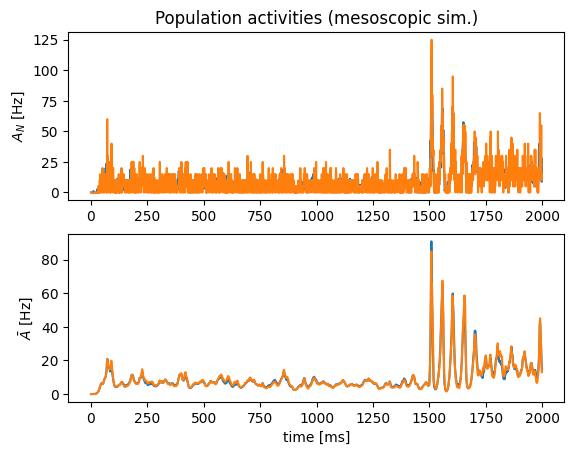

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, A_N * 1000)  # plot population activities (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.title('Population activities (mesoscopic sim.)')
plt.subplot(2, 1, 2)
plt.plot(t, Abar * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')

2000


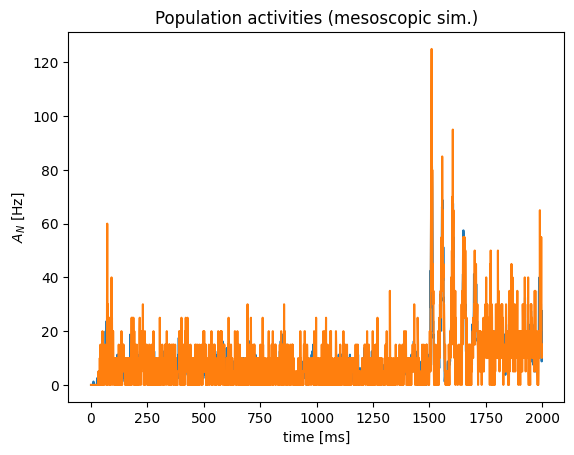

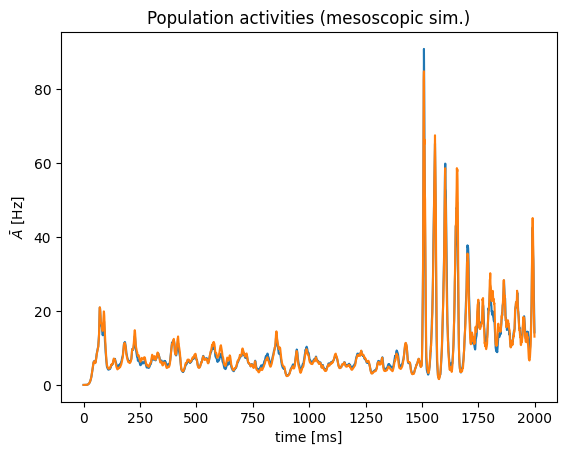

In [ ]:
plt.figure()
plt.plot(t, A_N * 1000)  # plot population activities (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
plt.figure()
plt.plot(t, Abar * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
print(len(A))

## Microscopic model

In [ ]:
nest.ResetKernel()
nest.resolution = dt
nest.print_time = True
nest.local_num_threads = 1

t0 = nest.biological_time

nest_pops = []
for k in range(M):
    nest_pops.append(nest.Create('gif_psc_exp', N[k]))

# set single neuron properties
for i in range(M):
    nest_pops[i].set(C_m=C_m,
                     I_e=mu[i] * g_L[i],
                     lambda_0=c[i],
                     Delta_V=Delta_u[i],
                     g_L=g_L[i],
                     tau_sfa=tau_theta[i],
                     q_sfa=J_theta[i] / tau_theta[i],
                     V_T_star=V_th[i],
                     V_reset=V_reset[i],
                     t_ref=t_ref[i],
                     tau_syn_ex=max([tau_ex, dt]),
                     tau_syn_in=max([tau_in, dt]),
                     E_L=V_rest[i],
                     V_m=V_rest[i])

# connect the populations
for i, nest_i in enumerate(nest_pops):
    for j, nest_j in enumerate(nest_pops):
        if np.allclose(pconn[i, j], 1.):
            conn_spec = {'rule': 'all_to_all'}
        else:
            conn_spec = {
                'rule': 'fixed_indegree', 'indegree': int(pconn[i, j] * N[j])}

        nest.Connect(nest_j, nest_i,
                     conn_spec,
                     syn_spec={'weight': J_syn[i, j] * g_syn[i, j],
                               'delay': delay[i, j]})

# monitor the output using a multimeter and a spike recorder
nest_sr = []
for i, nest_i in enumerate(nest_pops):
    nest_sr.append(nest.Create('spike_recorder'))
    nest_sr[i].time_in_steps = True

    # record all spikes from population to compute population activity
    nest.Connect(nest_i, nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

Nrecord = [5, 0]    # for each population "i" the first Nrecord[i] neurons are recorded
nest_mm_Vm = []
for i, nest_i in enumerate(nest_pops):
    nest_mm_Vm.append(nest.Create('multimeter'))
    nest_mm_Vm[i].set(record_from=['V_m'], interval=dt_rec)
    if Nrecord[i] != 0:
        nest.Connect(nest_mm_Vm[i], nest_i[:Nrecord[i]], syn_spec={'weight': 1., 'delay': dt})

# create the step current devices if they do not exist already
nest_stepcurrent = nest.Create('step_current_generator', M)
# set the parameters for the step currents
for i in range(M):
    nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                            amplitude_values=step[i] * g_L[i],
                            origin=t0,
                            stop=t_end)
    nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                            amplitude_values=step[i] * g_L[i],
                            origin=t0,
                            stop=t_end)
    # optionally a stopping time may be added by: 'stop': sim_T + t0
    pop_ = nest_pops[i]
    nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

# start the microscopic simulation
nest.rng_seed = 1

t = np.arange(0., t_end, dt_rec)
A_N = np.ones((t.size, M)) * np.nan

# simulate 1 step longer to make sure all t are simulated
nest.Simulate(t_end + dt)

for i in range(len(nest_pops)):
    data_sr = nest_sr[i].get('events', 'times') * dt - t0
    bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
    A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
    A_N[:, i] = A * 1000  # in Hz

Text(0.5, 1.0, 'Population activities (microscopic sim.)')

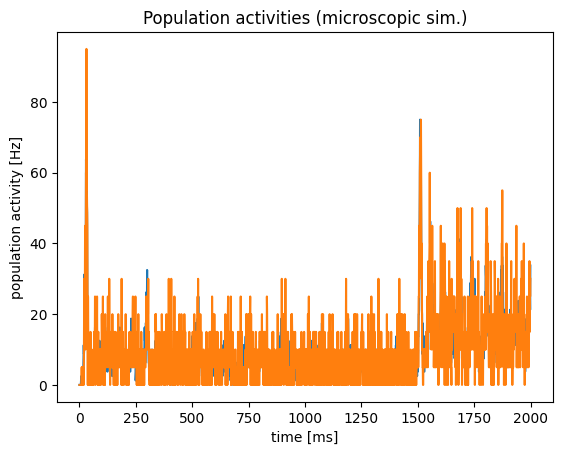

In [ ]:
# t = np.arange(dt, t_end + dt, dt_rec)

plt.figure()
plt.plot(t, A_N)
plt.xlabel('time [ms]')
plt.ylabel('population activity [Hz]')
plt.title('Population activities (microscopic sim.)')

## End